## Kelin dataset
* Klein et al., 2015
* GSE65525

In [1]:
library(Seurat)
library(M3Drop)
library(dplyr)
sessionInfo()

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3

Loading required package: numDeriv


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 14.04.6 LTS

Matrix products: default
BLAS/LAPACK: /path/to/envs/seuratV3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_0.8.3         M3Drop_1.10.0       numDeriv_2016.8-1.1
[4] Seurat_3.0.2       

loaded via a namespace (and not attached):
  [1] nlme_3.1-141        tsne_0.1-3          matrixStats_0.54.0 
  [4] bitops_1.0-6        RColorBrewer_1.1-2  httr_1.4.1         
  [7] repr_0.19.2         backports_1.1.4     sct

In [2]:
## Load data
counts <- read.csv2("/path/to/data/Klein_GSE65525/GSM1599495_ES_d0_biorep_techrep1.csv.bz2", 
                    header = FALSE, sep = ",", row.names = 1)

In [3]:
dim(counts)
head(counts)

[1] 24175  2509

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V2501,V2502,V2503,V2504,V2505,V2506,V2507,V2508,V2509,V2510
0610005C13Rik,0,0,0,1,1,0,0,0,0,0,...,0,1,0,0,2,0,0,0,0,0
0610007P14Rik,0,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
0610009B22Rik,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
0610009L18Rik,0,0,0,0,0,0,0,1,0,1,...,0,1,0,0,0,0,1,0,0,0
0610009O20Rik,2,0,0,1,0,0,1,2,0,0,...,2,0,1,0,1,0,2,1,1,2
0610010B08Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
object <- CreateSeuratObject(counts = counts, project = "klein", min.cells = 3, min.features = 200)


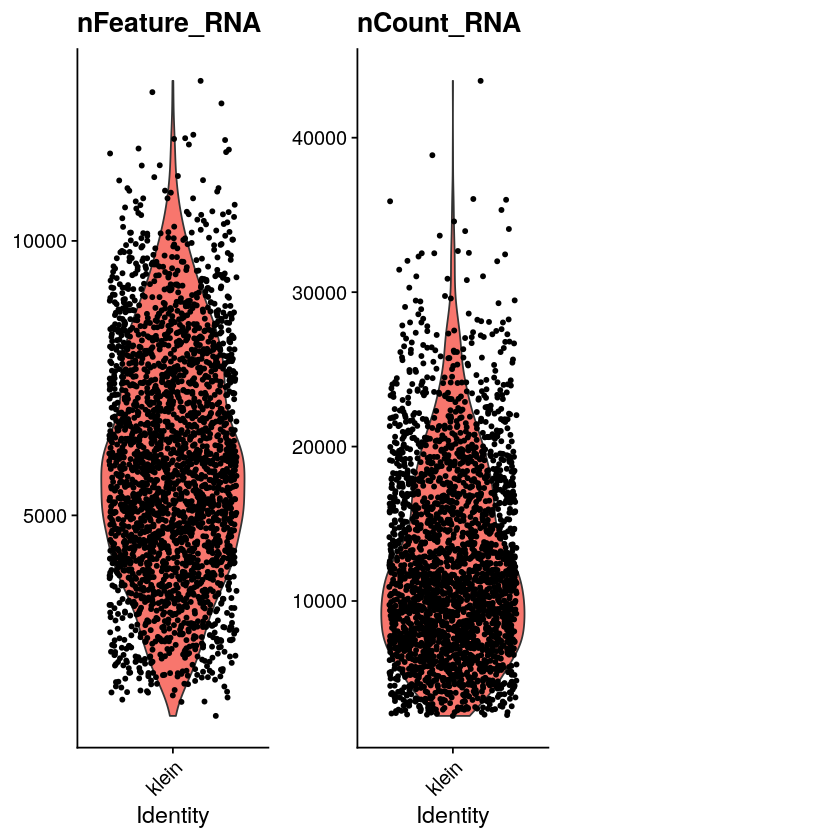

In [5]:
# Visualize QC metrics as a violin plot
VlnPlot(object, features = c("nFeature_RNA", "nCount_RNA"), ncol = 3)

In [6]:
object <- subset(object, subset = nFeature_RNA > 2000)

In [7]:
object


An object of class Seurat 
23980 features across 2485 samples within 1 assay 
Active assay: RNA (23980 features)

## NBumi

* A depth-adjusted negative binomial model (DANB)
* Functions relating to the DANB model are tagged with the ”NBumi” prefix



In [8]:
## Load data from raw count matrix 
count_mat <- NBumiConvertData(counts, is.log = FALSE, is.counts = TRUE)

[1] "Removing  145 undetected genes."


* Fit the DANB model to this count matrix, and check it fits the data

[1]  22903910 123680257


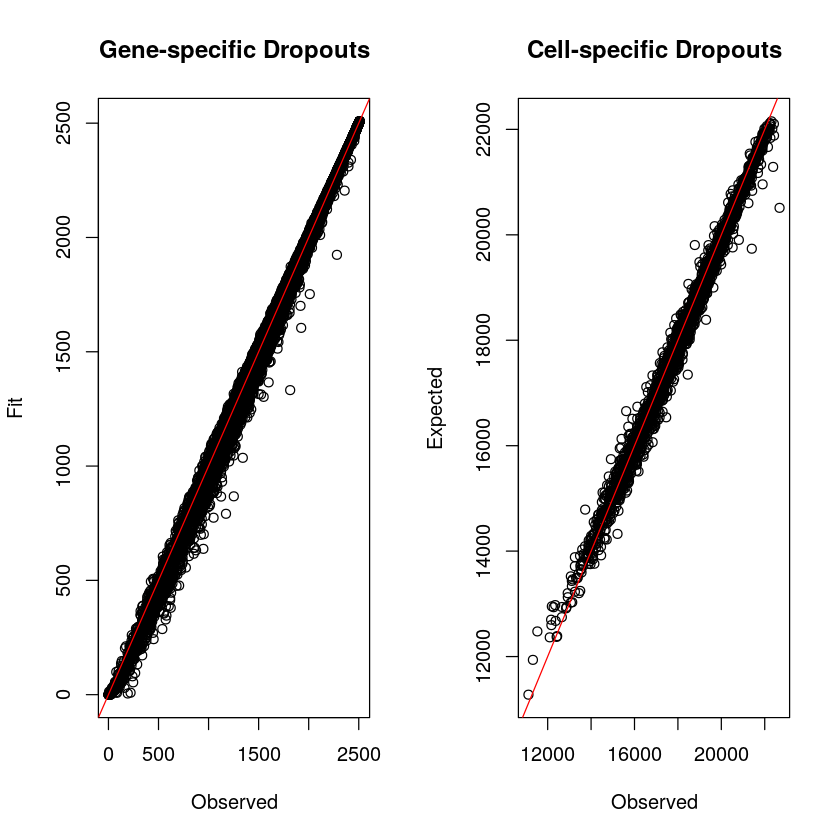

In [9]:
DANB_fit <- NBumiFitModel(count_mat)
par(mfrow=c(1,2))
stats <- NBumiCheckFitFS(count_mat, DANB_fit)
print(c(stats$gene_error,stats$cell_error))

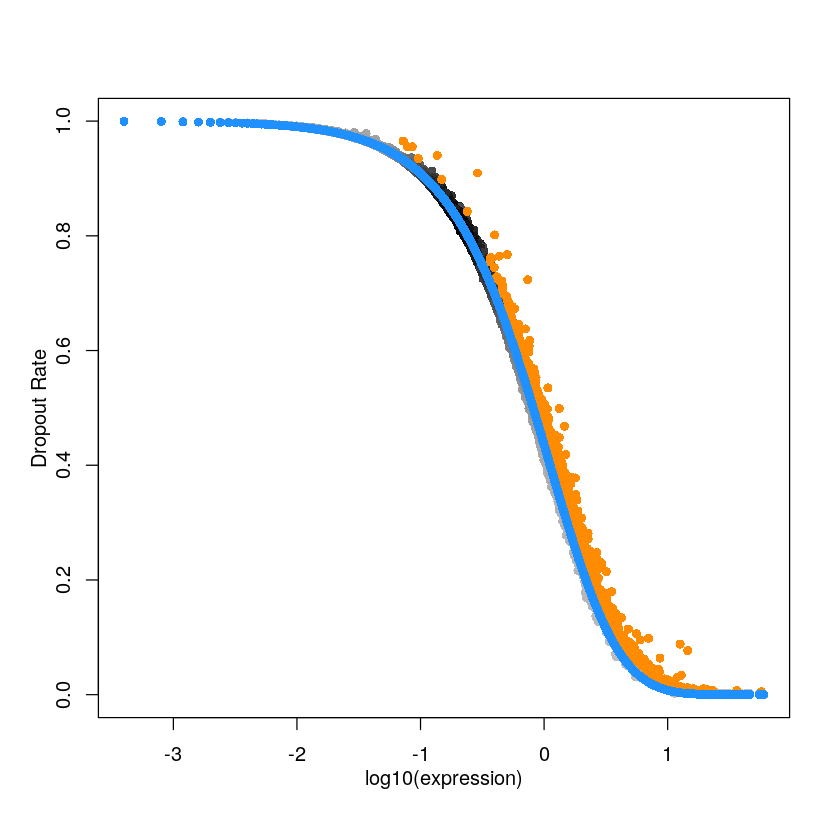

In [10]:
NBDropFS <- NBumiFeatureSelectionCombinedDrop(DANB_fit, method="fdr", qval.thres=0.05, suppress.plot=FALSE)

In the above plot:
* Each point a gene
* colored by local density of point arounf it (black => high density)
* Blue line the fitted relationship between mean and dropout rate
* Orange point significant features

In [11]:
head(NBDropFS)

,Gene,effect_size,p.value,q.value
Gm7102,Gm7102,0.19240864,1.163072e-49,2.794863e-45
Hist1h2ap,Hist1h2ap,0.08462161,6.354221e-49,7.634596e-45
Rn7sk,Rn7sk,0.14267261,2.771426e-46,2.219913e-42
Hist1h2ao,Hist1h2ao,0.07489772,3.793763e-44,2.279103e-40
Malat1,Malat1,0.07695892,4.935036e-32,2.371778e-28
Id1,Id1,0.15254821,4.158919e-31,1.665647e-27


In [12]:
selectedGenes <- NBDropFS$Gene
length(selectedGenes)


[1] 736

### Resume with the rest of the Seurat workflow

In [13]:
## Normalizing the data
object <- NormalizeData(object, normalization.method = "LogNormalize", scale.factor = 10000)

## Scaling the data
all.genes <- rownames(object)
object <- ScaleData(object, features = all.genes)

Centering and scaling data matrix



In [14]:
## Identify high variable features
object <- FindVariableFeatures(object, selection.method = "vst", nfeatures = 2000)

In [15]:
## Overlap the set of genes from NBDROP with the 2000 most variable genes
length(which(selectedGenes %in% VariableFeatures(object = object)))

[1] 354

In [16]:
## Perform linear dimensional reduction
object <- RunPCA(object, features =  selectedGenes)

PC_ 1 
Positive:  1300002K09Rik, 1110036E04Rik, 1700026D08Rik, 2200002D01Rik, 1810009A15Rik, 1110057K04Rik, 1700037H04Rik, 2410015M20Rik, 2310036O22Rik, 2810025M15Rik 
	   1110004F10Rik, 2810021J22Rik, 1810058I24Rik, 2700094K13Rik, 1700073E17Rik, 2810474O19Rik, 1700017B05Rik, 0610031J06Rik, 1700010I14Rik, 0610009O20Rik 
	   1110037F02Rik, 1700010I02Rik, 1110038F14Rik, 2810004N23Rik, 2210016F16Rik, 1110001J03Rik, 1300002E11Rik, 2700049A03Rik, 2610528J11Rik, 1700020N01Rik 
Negative:  2500004C02Rik, 1700065J18Rik, 3110001I22Rik, 2610028H24Rik, 1700047I17Rik2, 1810010H24Rik, 2610034B18Rik, 2310065F04Rik, 3110043O21Rik, 1700122O11Rik 
	   1700044C05Rik, 2810008D09Rik, 2310061N02Rik, 2300009A05Rik, 2210414B05Rik, 3110082J24Rik, 2810471M01Rik, 1200014J11Rik, 1700067G17Rik, 2700038G22Rik 
	   1700012D14Rik, 2810047C21Rik1, 1700029P11Rik, 1700034E13Rik, 2310008N11Rik, 2610027K06Rik, 3110079O15Rik, 1700067P10Rik, 1700012L04Rik, 1600014C10Rik 
PC_ 2 
Positive:  2500004C02Rik, 1700047I17Rik2, 1200

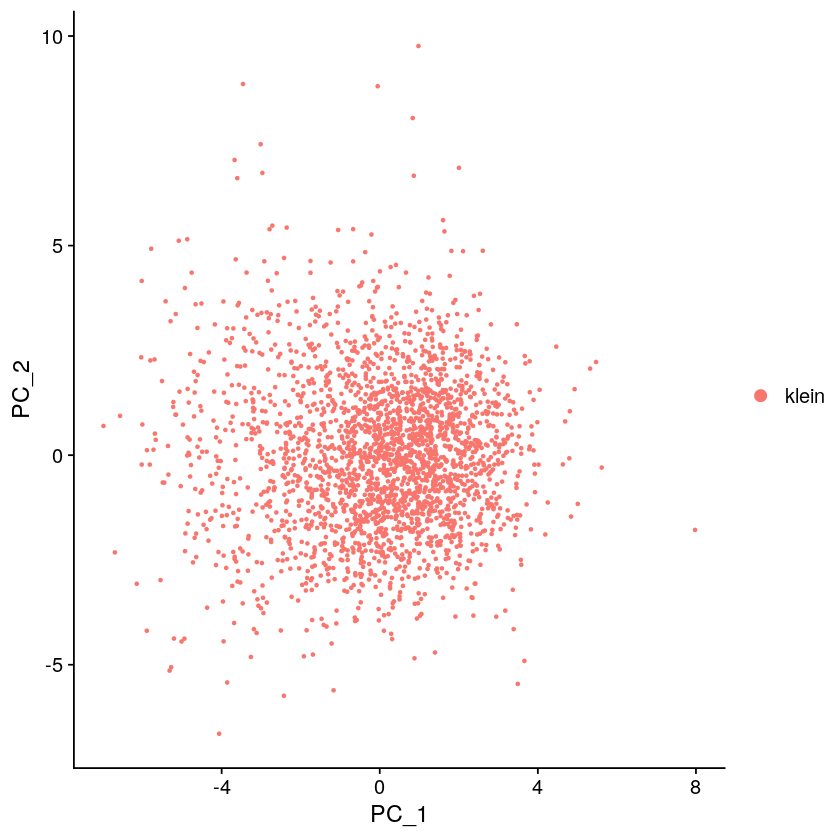

In [17]:
DimPlot(object, reduction = "pca")

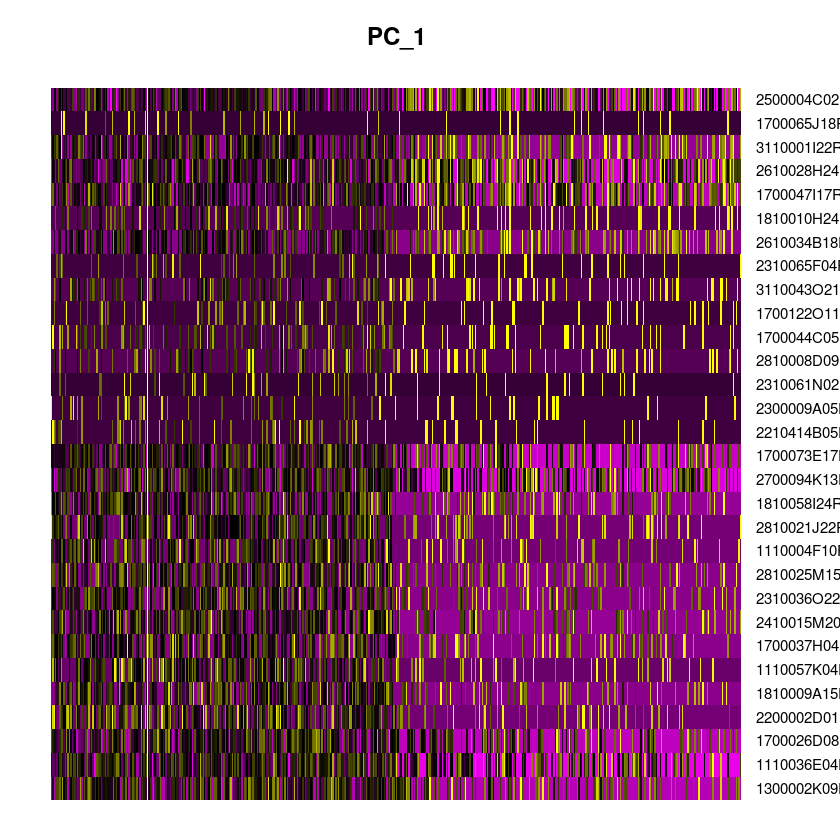

In [18]:
DimHeatmap(object, dims = 1, cells = 500, balanced = TRUE)

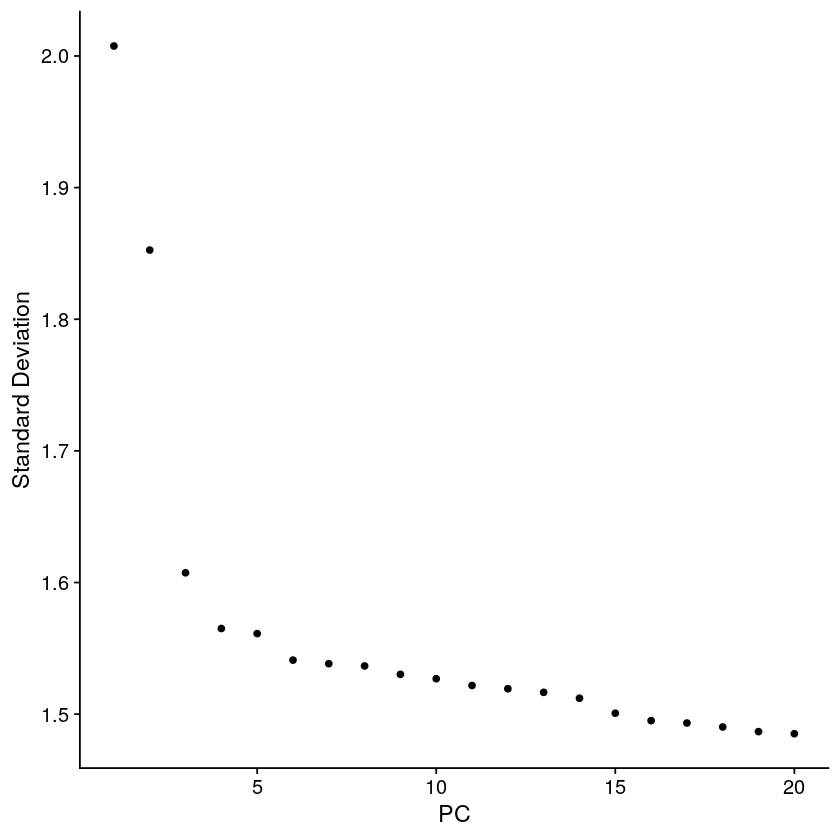

In [19]:
ElbowPlot(object)

In [20]:
object <- FindNeighbors(object, dims = 1:10)
object <- FindClusters(object, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2485
Number of edges: 76852

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6115
Number of communities: 3
Elapsed time: 0 seconds


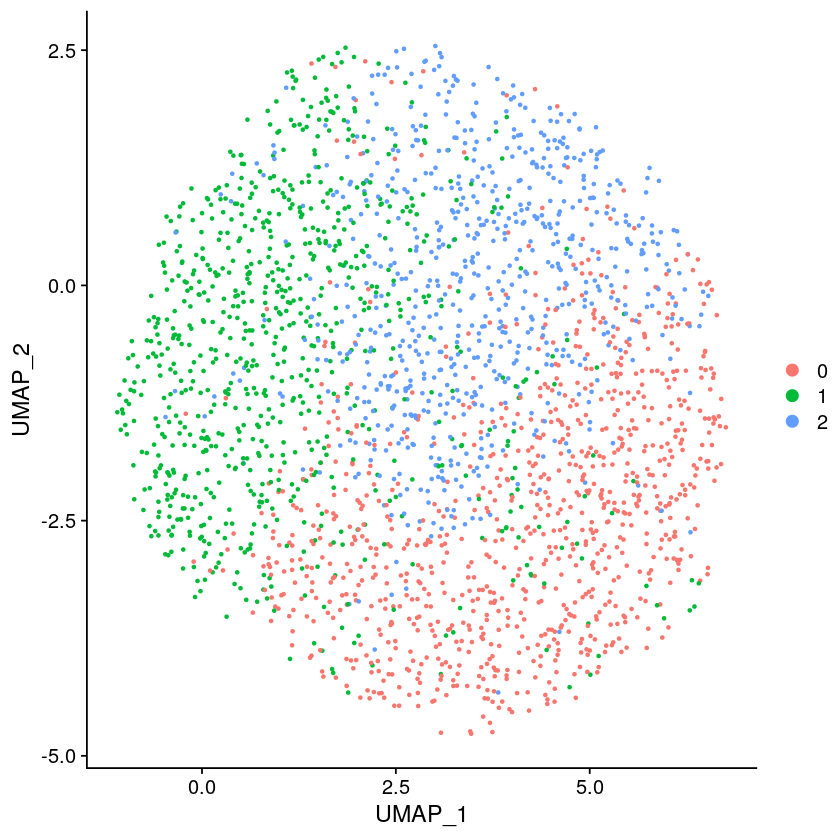

In [21]:
object <- RunUMAP(object, dims = 1:10)
DimPlot(object, reduction = "umap")

## Redo with the standard Seurat workflow

In [22]:
object <- RunPCA(object, features = VariableFeatures(object = object))

PC_ 1 
Positive:  Tuba1b, Malat1, Aldoa, Ube2s, Pfn1, Klf2, Eif2s2, E130012A19Rik, Zfp42, Tuba1c 
	   H2afz, Ubald2, H2afv, Marcksl1, Lsm4, Fkbp4, Slc2a1, Tubb2b, Upp1, Ppp1r14b 
	   Lamtor2, Slc25a5, Pgk1, Chchd10, H2afx, Ahsa1, Mrpl12, Ost4, Utf1, Rhoa 
Negative:  Tor4a, Pbld1, Abcd4, Mfsd11, Cd3eap, Rn4.5s, Camk4, Lmbrd1, Shc2, Slc35g1 
	   Hpgds, Snhg11, Pla2g4b, Jmjd7-pla2g4b, Rn28s1, Pwwp2a, Dgke, Ccdc36, Lgr5, H2-T23 
	   Pcyox1, Lrrc14b, Bc1, Rn7sk, Lrrc7, Mrpl19, Hsdl1, Rn7s1, Rn7s2, Rab33b 
PC_ 2 
Positive:  Ldhb, Acer2, Dhx16, Fabp3, Mir6240, H19, Asns, Gstm1, Slc2a3, Maged1 
	   Dcxr, Psrc1, 1700007K13Rik, Sdc4, Lrpap1, Rtca, Rn18s, Cd63, F830016B08Rik, Anxa6 
	   Slc25a20, Glrx3, Rest, Insl3, Klf4, Ifitm1, Cox6b2, Cdkn1a, Anxa8, Jak3 
Negative:  Ccdc36, Bc1, Ahcyl2, Abcd4, Cd3eap, Camk4, Lmbrd1, Pbld1, Tor4a, Snhg11 
	   Mfsd11, A730056A06Rik, Slc35g1, Lrrc14b, Pwwp2a, Hpgds, Zxda, Gjd2, Dgke, Aipl1 
	   Jmjd7-pla2g4b, Pla2g4b, Lrrc7, Lgr5, H2-T23, BC020402, Kazald1, Oxgr1

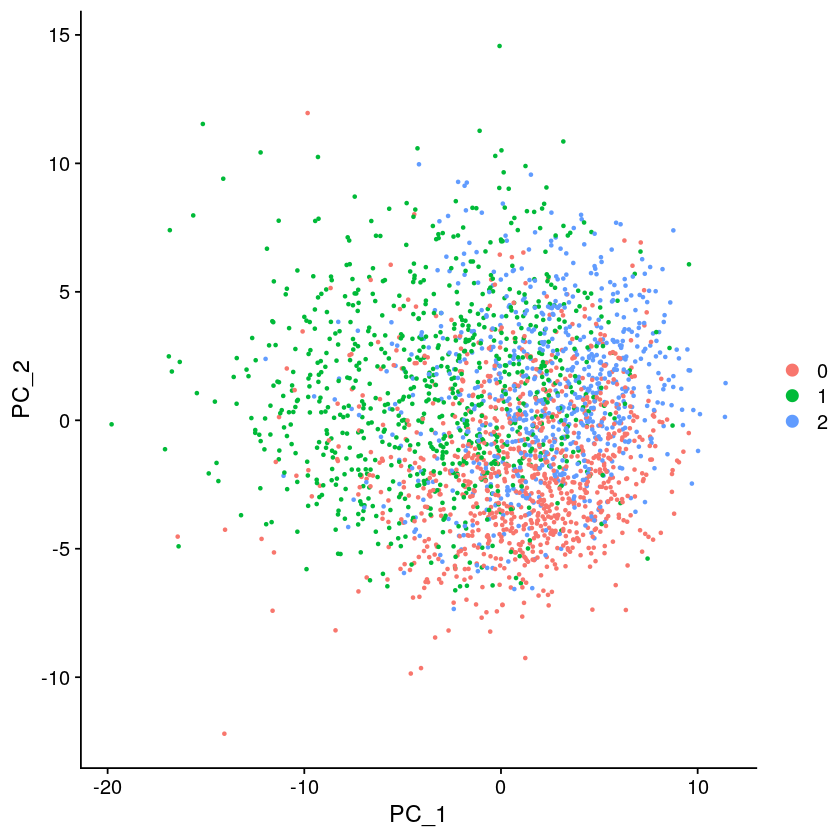

In [23]:
DimPlot(object, reduction = "pca")

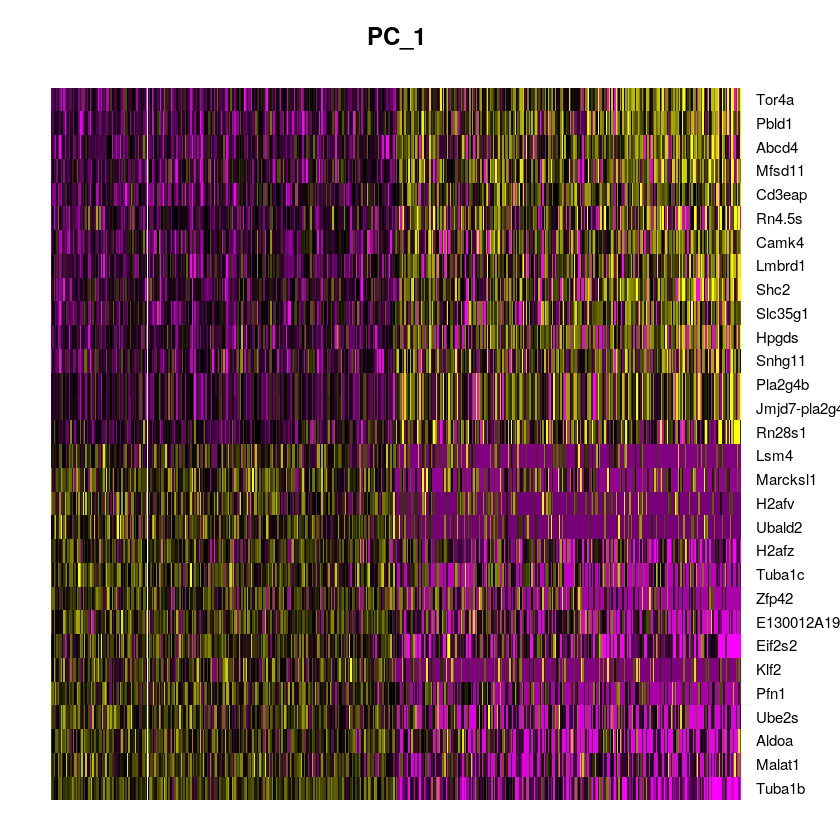

In [24]:
DimHeatmap(object, dims = 1, cells = 500, balanced = TRUE)

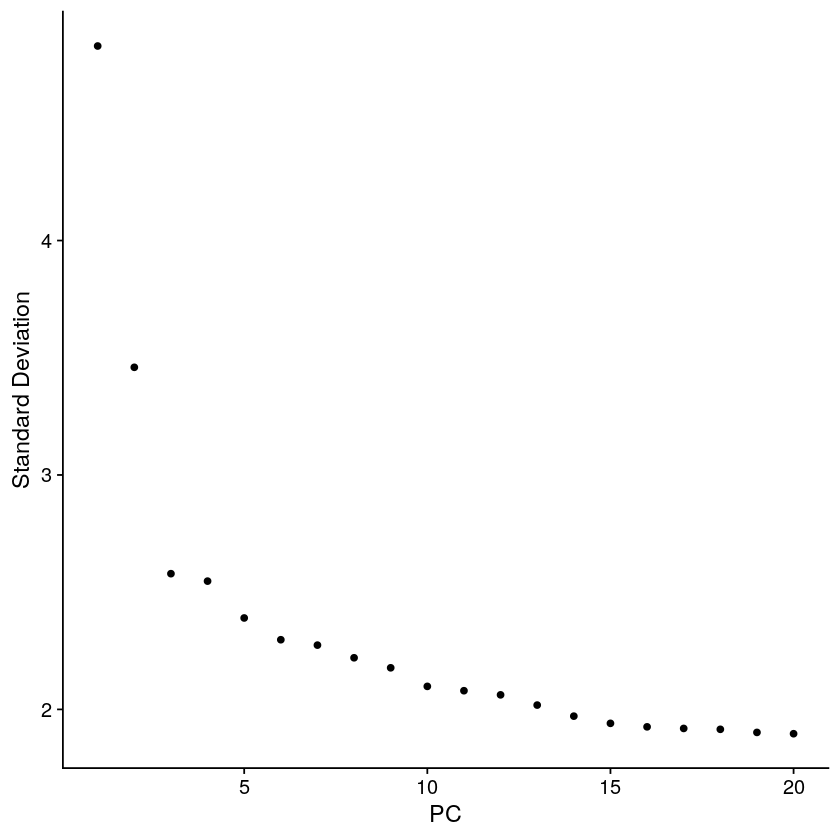

In [25]:
ElbowPlot(object)

In [26]:
object <- FindNeighbors(object, dims = 1:10)
object <- FindClusters(object, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2485
Number of edges: 80081

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7061
Number of communities: 5
Elapsed time: 0 seconds


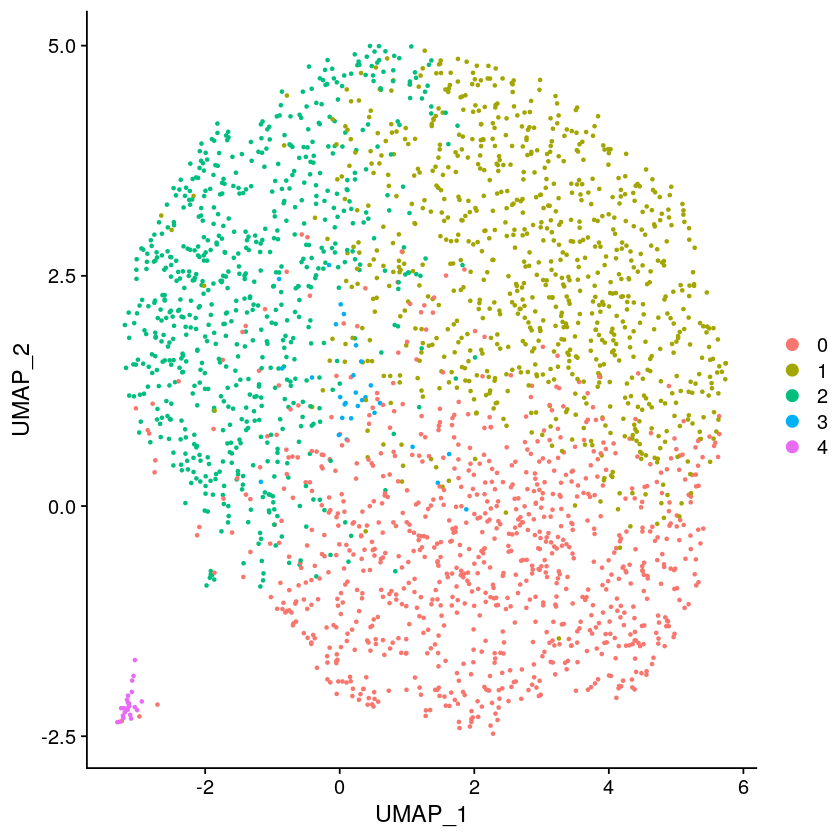

In [27]:
object <- RunUMAP(object, dims = 1:10)
DimPlot(object, reduction = "umap")

In [28]:
VariableFeatures(object = object)

[1] "Rn7sk"         "Rn28s1"        "Rn4.5s"        "Gm7102"       
   [5] "Dcdc2c"        "H19"           "Rn45s"         "Zfp866"       
   [9] "Gm20767"       "Rhox5"         "Gm5039"        "AF067061"     
  [13] "Mei4"          "Col4a1"        "Dixdc1"        "Zscan4f"      
  [17] "Gdf2"          "Tcstv1"        "Zscan4d"       "Rn18s"        
  [21] "Serpinh1"      "Cd44"          "Rs5-8s1"       "Bc1"          
  [25] "Rnu1b6"        "Id1"           "Gm5662"        "2310039L15Rik"
  [29] "Rn7s1"         "Rn7s2"         "Kdm1b"         "Mir6240"      
  [33] "Zscan4c"       "Gm4027"        "Hist1h2ao"     "Rnu1a1"       
  [37] "Csf1r"         "Usp17la"       "Hist1h2ap"     "Zscan4a"      
  [41] "Ccdc36"        "Ldhb"          "Gm2022"        "C430002E04Rik"
  [45] "Gata6"         "Tcstv3"        "Tmem92"        "Mir3544"      
  [49] "Sparc"         "Gm1995"        "Sox3"          "Gm8994"       
  [53] "B020031M17Rik" "Aipl1"         "Malat1"        "Cd14"         
  [57] "Gm7104"        "Trim71"        "A430089I19Rik" "Trem2"        
  [61] "Lamb1"         "Olfr1348"      "3110062M04Rik" "Lama1"        
  [65] "Glipr2"        "Igsf11"        "Trh"           "Ddit3"        
  [69] "Sfn"           "AF067063"      "Gm6878"        "2700046A07Rik"
  [73] "Mir6538"       "Id3"           "Cep83"         "Ifitm1"       
  [77] "Krt85"         "Rhoj"          "Sbk1"          "Taf1a"        
  [81] "Rnu6"          "S100a6"        "Cd63"          "Hspa5"        
  [85] "Apoe"          "Tiam1"         "Gm4301"        "Gm4312"       
  [89] "Fbxo47"        "Gm19345"       "AA474331"      "Hes2"         
  [93] "Ahcyl2"        "Ly6a"          "BB287469"      "H2afx"        
  [97] "Cdkn1a"        "Hbegf"         "Fndc3b"        "Wif1"         
 [101] "Mir690"        "Uts2"          "Mt1"           "Amn"          
 [105] "Foxp1"         "Syce3"         "Ifitm3"        "Spata31d1d"   
 [109] "Esrp2"         "Tmem91"        "Hist1h1e"      "Wdr48"        
 [113] "Bcl2"          "LOC100503496"  "Mir6941"       "Drd2"         
 [117] "Herpud1"       "Gm20594"       "Ptcd2"         "Olfr1373"     
 [121] "Erf"           "Pdgfa"         "Zscan4b"       "Gm8300"       
 [125] "Cldn2"         "Fam25c"        "Bhmt"          "Mylpf"        
 [129] "Mir6236"       "Gjd2"          "Kazald1"       "Krt8"         
 [133] "Mir5046"       "Rhox13"        "Rhox9"         "Rpl39l"       
 [137] "F830016B08Rik" "Gm2016"        "Mt2"           "Sdc4"         
 [141] "Lrpap1"        "Mir1957a"      "Slc2a1"        "Fabp3"        
 [145] "Ears2"         "Rarg"          "Slc27a5"       "Rpph1"        
 [149] "Prr13"         "Slc29a1"       "Smarcd3"       "A730056A06Rik"
 [153] "2410006H16Rik" "Ccnd3"         "Gbx2"          "Pcyox1"       
 [157] "G0s2"          "Mtrr"          "1700007K13Rik" "Upp1"         
 [161] "Tcf15"         "Ikbip"         "Asb14"         "5430434I15Rik"
 [165] "D3Ertd254e"    "Zfp296"        "Dok2"          "BC020402"     
 [169] "Hpgds"         "Spry4"         "Gjb3"          "Gm15114"      
 [173] "n-R5s136"      "Gm5617"        "Caln1"         "Vim"          
 [177] "Htra1"         "Surf4"         "Lgals1"        "Rgs2"         
 [181] "Oxgr1"         "Cdh24"         "Gpx3"          "Mir7687"      
 [185] "Insl3"         "H6pd"          "Wdr25"         "Cd99"         
 [189] "Calcoco2"      "E130012A19Rik" "Ncstn"         "Itpk1"        
 [193] "Pcolce"        "Krt42"         "Rhox6"         "Tax1bp3"      
 [197] "Rnd2"          "AU040972"      "Tmsb4x"        "Rnu1b1"       
 [201] "Rnu1b2"        "Chac1"         "Id2"           "Tbc1d21"      
 [205] "Lamc1"         "Foxq1"         "Dnmt3l"        "Tppp3"        
 [209] "Glul"          "Kdm4b"         "Ninj1"         "Dlk2"         
 [213] "Mir7225"       "Plrg1"         "Hmox1"         "Klf5"         
 [217] "Pfn1"          "Sry"           "Mir762"        "Nodal"        
 [221] "Hist1h2ah"     "Cxx1a"         "Trib3"         "Dcxr"         
 [225] "Gm7325"        "Tub